# Evaluating learning algorithms
Also see Chapter 5: Credibility - evaluating what's been learned

In [150]:
# Global imports and settings
from preamble import *
#%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['savefig.dpi'] = 120 # Use 300 for PDF, 100 for slides
# InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

## Evaluating learning models
To know whether we can _trust_ what our algorithm has learned, we need to evaluate it.

We will focus on supervised methods (classification and regression)

- With the labels we can objectively evaluate models
- There are still many ways to do this

In unsupervised learning (e.g. clustering) we don't know what the 'right' output should be

- We can only optimize for certain properties (e.g. cluster purity)
- Ultimately, we need to inspect results manually (or use external evaluation measure)

## Generalization, Overfitting and Underfitting
* We __hope__ that the model can _generalize_ from the training to the test data: make accurate predictions on unseen data
* It's easy to build a complex model that is 100% accurate on the training data, but very bad on the test data
* Overfitting: building a model that is _too complex for the amount of data_ that we have
    * You model peculiarities in your data (noise, biases,...)
    * Solve by making model simpler (regularization), or getting more data
* Underfitting: building a model that is _too simple given the complexity of the data_
    * Use a more complex model
* There is often a sweet spot that you need to find by optimizing the choice of algorithms and hyperparameters, or using more data.  

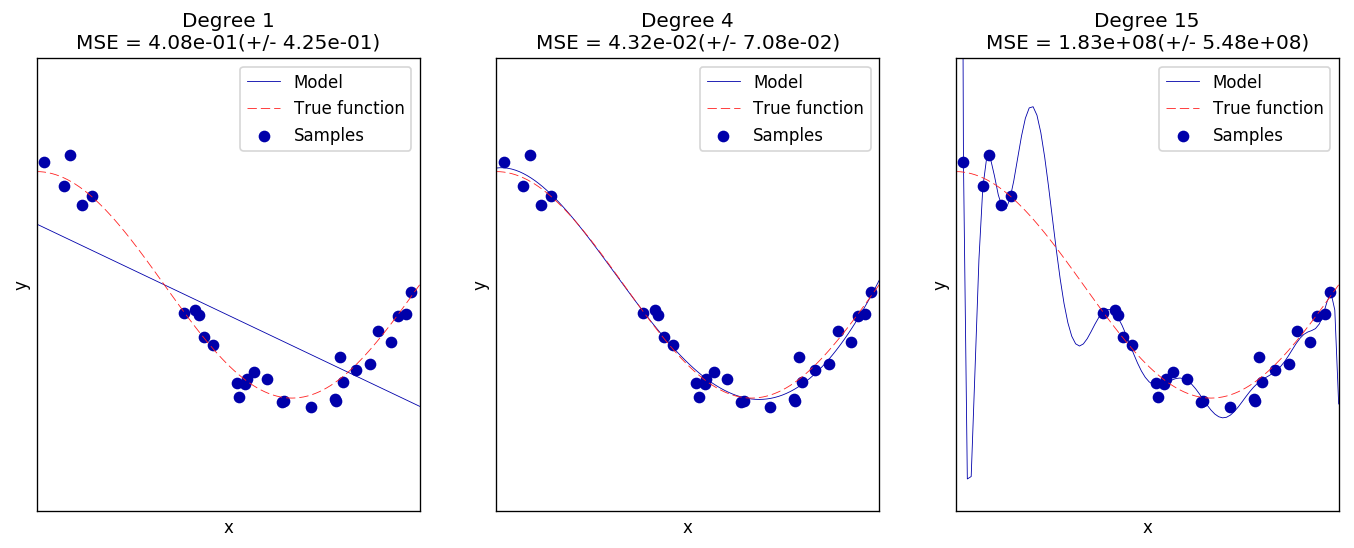

In [34]:
# Add a list of degrees to observe the effect of overfitting
ml.plots.plot_overfitting([1,4,15])

## The holdout (simple train-test split)

The most basic form of evaluation:

- Split data into training and test set (e.g. 75%-25%)
- Train (fit) a model on the training data
- Evaluate the trained model on the test data (comparing predicted and true labels)
    - We are interested in how well the model _generalizes_ to new (test) data

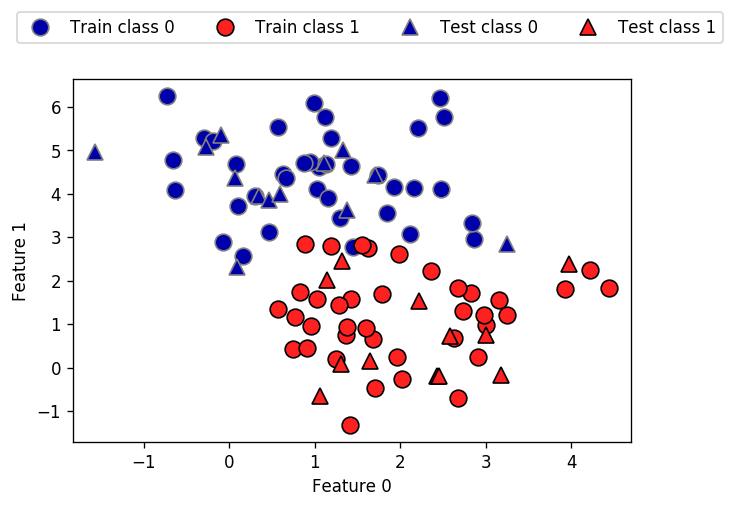

In [35]:
# Illustrates a standard holdout for a given umber of points
ml.plots.plot_holdout(100)

In WEKA: `percentage split`
![weka holdout](./images/07_weka_holdout.png)

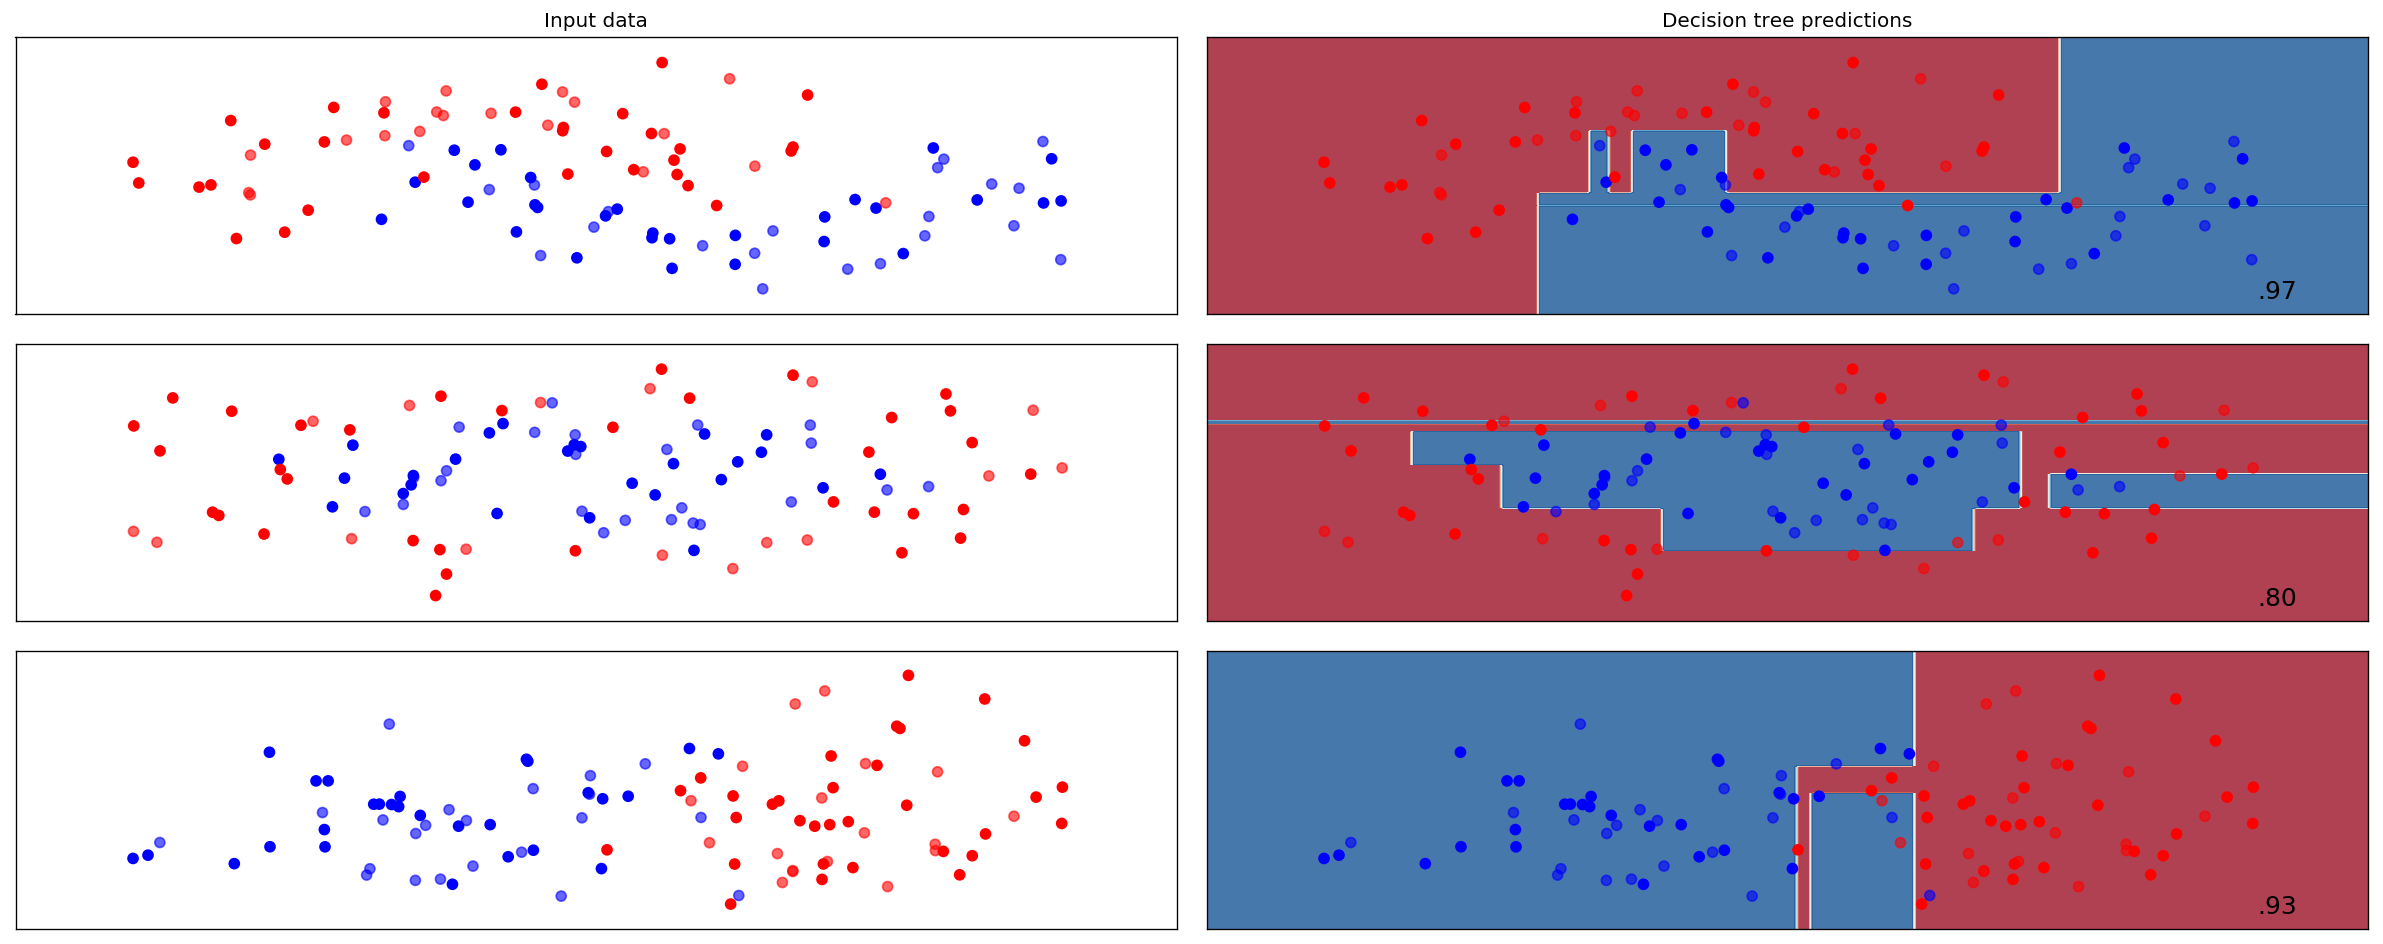

In [36]:
# Visualize how a decision tree trises to model the data
# Background color are predictions made by the tree
# You can see misclassifications (and overfitting)
ml.plots.plot_holdout_predict_tree()

Limitations to using a simple train-test split?

* Why 75%? Are there better ways to split?
* What if one random split yields different models (and scores) than another?
* What if all examples of one class all end up in the training/test set?

## Cross-validation

- More stable, thorough way to estimate generalization performance
- _k-fold cross-validation_ (CV): split (randomized) data into _k_ equal-sized parts, called _folds_
    - First, fold 1 is the test set, and folds 2-5 comprise the training set
    - Then, fold 2 is the test set, folds 1,3,4,5 comprise the training set
    - Compute _k_ evaluation scores, aggregate afterwards (e.g. take the mean)

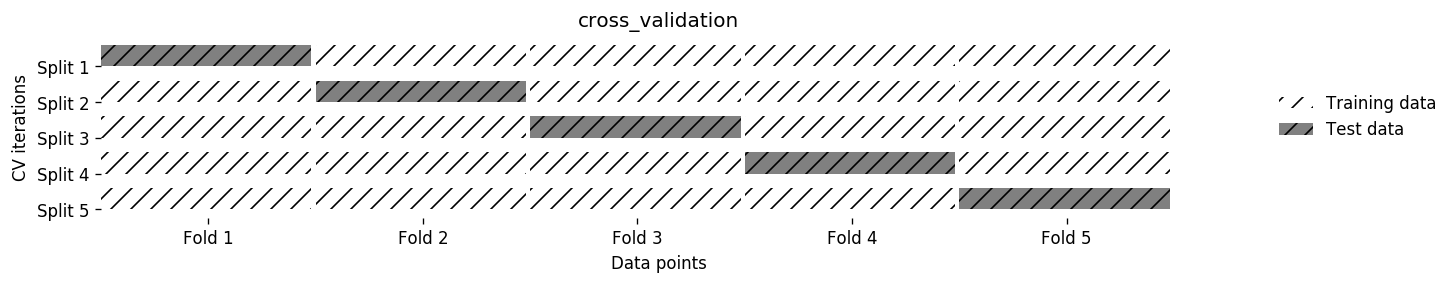

In [37]:
mglearn.plots.plot_cross_validation()

In WEKA: `Cross-validation`, default is 10-fold
![weka cv](./images/07_weka_cv.png)

You can see the per-fold evaluation results in the `Experimenter`:

* Open the Experimenter from the GUI Chooser
* Create a new experiment ('New' button top-right)
    * Set the Number of (cross-validation) folds
    * Add your dataset with 'Add new...'
    * Set the Number of repetitions to 1 (see later)
    * Add the algorithm with 'Add new...'
    * Go to the Run tab and Start the experiment and wait till it finishes
* Go to the Analyse tab
    * Import the experiment results by clicking Experiment (top-right)
    * For Row select: Fold
    * For Column select: Percent_correct
* You now see the specified results for each fold

![weka cv](./images/07_weka_cv_exp.png)
![weka cv](./images/07_weka_cv_exp2.png)

- We typically compute the mean and variance from these numbers
$$mean = \bar{x} = \frac{\sum_{i} x_i}{n}$$
$$variances = \sigma^2 = \frac{\sum_{i} (x_i-\bar{x})^2}{n-1}$$
$$standard\ deviation = \sigma$$

- Note that there can be quite some variance in the results
    - Depends on the stability of the model and the amount of training data
    - Typically, the more training data, the more stable the models

### Benefits of cross-validation
- More robust: every training example will be in a test set exactly once
    - Model is evaluated on all samples, needs to do well on all
    - With a train-test split, we can be
        - 'lucky': all easy examples in test set
        - 'unlucky: all hard examples in test set
- Shows how _sensitive_ the model is to the exact training set
- Better estimation of true performance
    - 10-fold CV uses 90% of all data for training (vs 75% for holdout)
    - The higher _k_, the more accurate the estimation
- Disadvantage: computational cost, roughly _k_ times slower than holdout

### Stratified K-Fold cross-validation

- If the data is _unbalanced_, some classes have many fewer samples
- Likely that some classes are not present in the test set 
- Stratification: make sure that _proportions_ between classes are conserved in each fold
    - Order examples per class
    - Separate the samples of each class in _k_ sets (strata)
    - Combine corresponding strate into folds

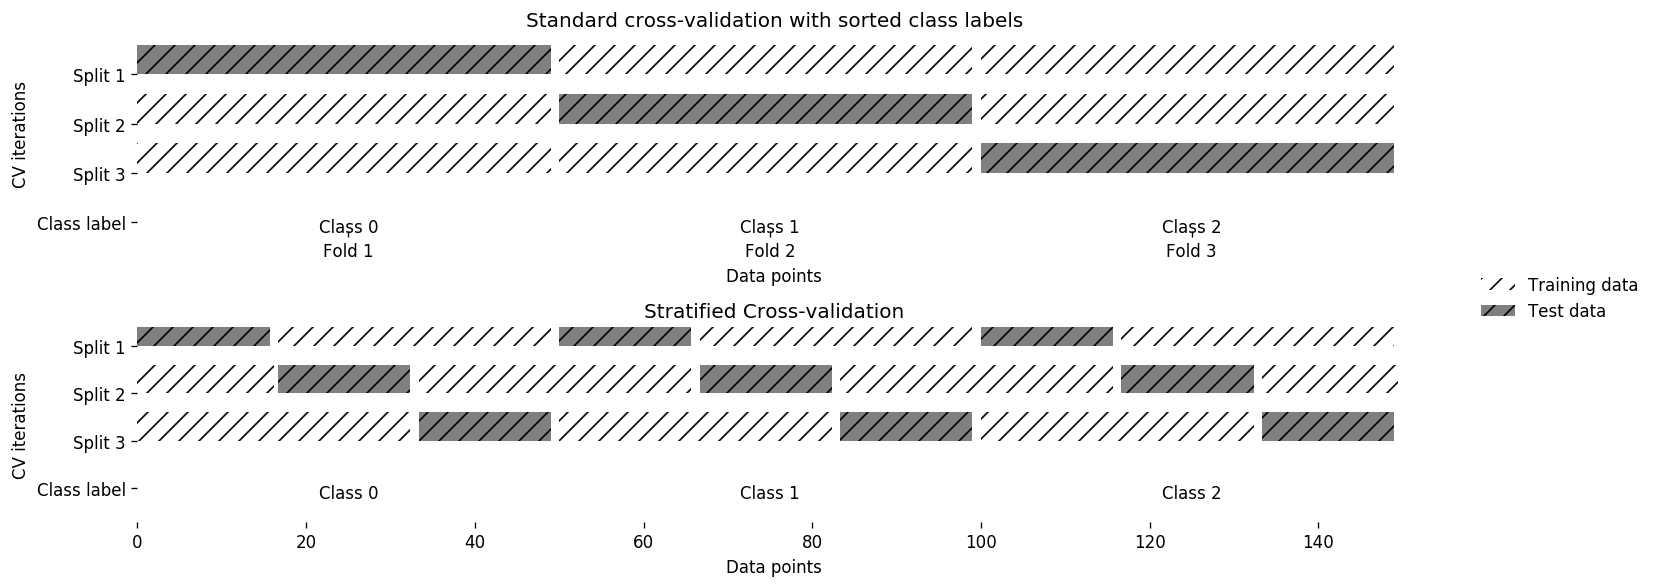

In [38]:
mglearn.plots.plot_stratified_cross_validation()

- Recommendation:
    - stratified cross-validation by default for classification
    - normal cross-validation for regression

### Leave-One-Out cross-validation

- _k_ fold cross-validation with _k_ equal to the number of samples
- Completely unbiased, but computationally expensive
- Recommended for small datasets, since training sets are large (n-1)
- Cannot be stratified, be careful when interpreting results
    - Worse case (random data and 50% positives), estimated error rate = 100%
    - Also, for very skewed class distributions, small classes are drowned out

### Shuffle-Split cross-validation

- Samples a number of samples (`train_size`) randomly as the training set, and a disjoint number of samples (`test_size`) as the test set
- Repeat this procedure `n_iter` times, obtaining `n_iter` scores
- Typically, the whole dataset is used each iteration (except for large datasets)
- Example with `train_size` = 10, `test_size` = 2, `n_iter` = 4
- Can also be done in a stratified way

![shuffle_split](./images/03_shuffle_split.png)

### Bootstrapping
- Related to Shuffle-split
- Sample _n_ (total number of samples) data points, with replacement, as training set (the bootstrap)
- Use the unsampled (out-of-bootstrap) samples as the test set
- Repeat `n_iter` times, obtaining `n_iter` scores

* In the WEKA GUI, you can't select bootstrap or shuffle-split instead of cross-validation
* You have to use the `Resample` filter, run multiple experiments, and average the results yourself.
    * `noReplacement`: Resample with (bootstrap) or without (shuffle-split) replacement
    * Use the holdout with the appropriate split size (0.63 for bootstrap)
    * You can prove that bootstraps include 63% of all data points on average
        * Chance that a specific sample is picked is $\frac{1}{n}$
        * Chance that a specific sample is _never_ being picked is $(1-\frac{1}{n})^n \approx e^{-1} = 0.368$
        * Hence, bootstraps contain (on average) 63.2% of the samples

![weka resample](./images/07_weka_resample.png)

### Repeated cross-validation
- Cross-validation is still biased in that the initial split can be made in many ways
- Repeated, or n-times-k-fold cross-validation:
    - Shuffle data randomly, do k-fold cross-validation
    - Repeat n times, yields n times k scores
- Unbiased, very robust, but n times more expensive
- In the `Experimenter`, you can set a number of iterations

![weka cv](./images/07_weka_cv_exp.png)

### Cross-validation with groups

- Sometimes the data contains inherent groups:
    - Blood analysis results on specific patients
    - Facial expressions of specific people
- With normal cross-validation, data from the same persion may end up in the training _and_ test set
- If we want to measure how well the model generalizes to _other_ people, this is undesirable
- We want to make sure that data points fom one person are in _either_ the training or test set
    - This is called _grouping_ or _blocking_
    - Leave-one-subject-out cross-validation: create test set for each user individually
- No way to do this in WEKA, but you can do it externally and then import the train-test splits
    - `Supplied test set` in the `Explorer`

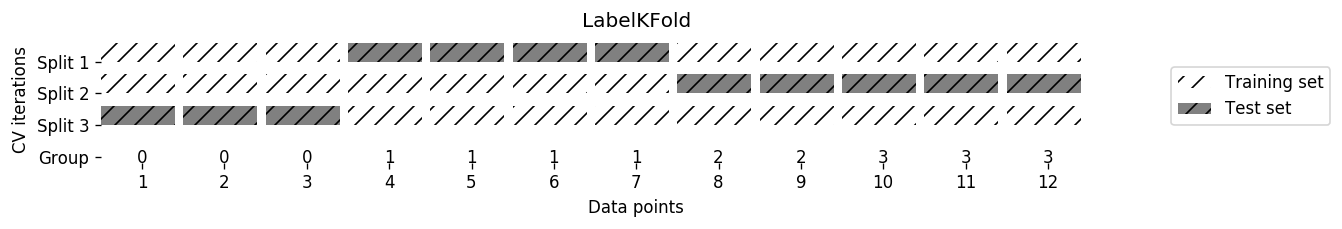

In [39]:
mglearn.plots.plot_group_kfold()

- In scikit-learn, this is supported by `GroupKFold`
    - Add an array with group membership to `cross_val_scores` 
    - Use `GroupKFold` with the number of groups as CV procedure

### Choosing a performance estimation procedure
No strict rules, only guidelines:

- Always use stratification for classification
- Use holdout for very large datasets (e.g. >1.000.000 examples)
    - Or when learners don't always converge (e.g. deep learning)
- Choose _k_ depending on dataset size and resources
    - Use leave-one-out for small datasets (e.g. <500 examples)
    - Use cross-validation otherwise
        - Most popular (and theoretically sound): 10-fold CV
        - Literature suggests 5x2-fold CV is better
- Use grouping or leave-one-subject-out for grouped data

## Hyperparameter tuning
Now that we know how to evaluate models, we can improve them by tuning their hyperparameters

There are many ways to _search_ for the best hyperparameter configuration:
- __Grid search__
- __Random search__
- Local search
- Racing algorithms
- __Model-based optimization__
- Multi-armed bandits
- Genetic algorithms

### Grid Search

- For each hyperparameter, create a list of interesting/possible values
    - E.g. For k-Nearest Neighbors: k in [1,3,5,7,9,11,33,55,77,99]
- Evaluate all possible combination of hyperparameter values
    - E.g. using cross-validation
- Select the hyperparameter values yielding the best results

* A naive approach would be to just loop over all combinations, and pick the best one
* This can be done in the 'Experimenter' by entering many algorithms with different hyperparameters

![weka cv](./images/07_weka_manual_grid.png)

#### Overfitting the parameters and the validation set
- Simply taking the best performing model yields optimistic results
- We've already used the test data to evaluate each hyperparameter setting
- Hence, we don't have an independent test set to evaluate these hyperparameter settings
    - Information 'leaks' from test set into the final model
- Solution: Set aside part of the training data to evaluate the hyperparameter settings
    - Select best hyperparameters on validation set
    - Rebuild the model on the training+validation set
    - Evaluate optimal model on the test set

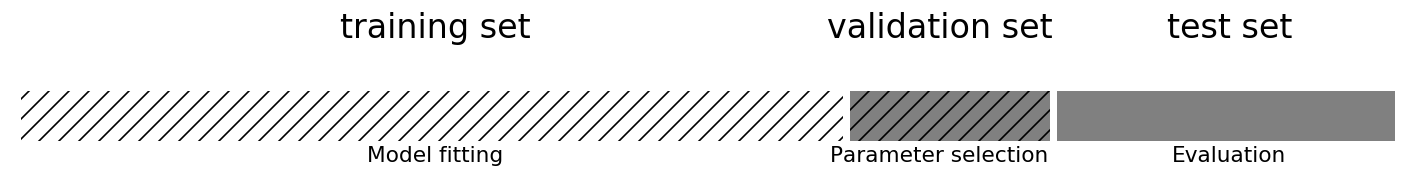

In [40]:
mglearn.plots.plot_threefold_split()

#### Grid-search with cross-validation

- Same problem as before: the way that we split the data into training, validation, and test set may have a large influence on estimated performance
- We need to use cross-validation again, instead of a single split
- Expensive. Often, 5-fold CV is enough

Overall process

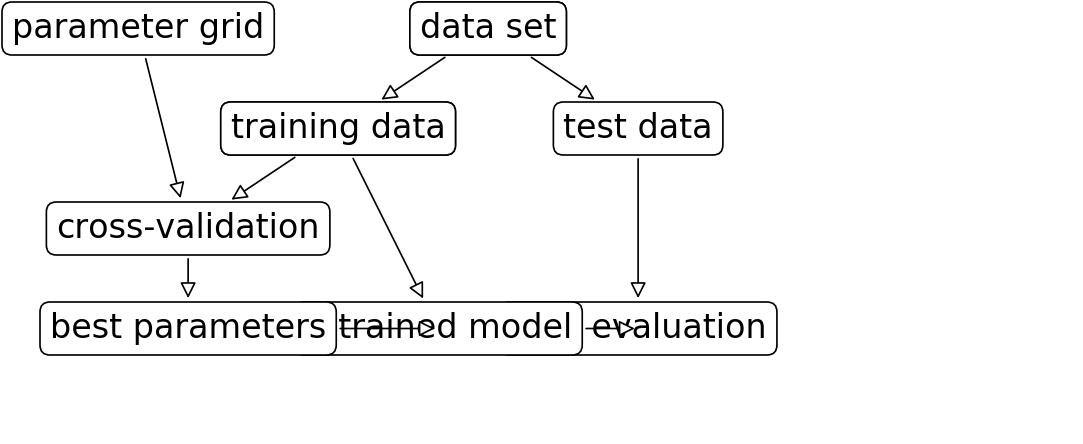

In [41]:
mglearn.plots.plot_grid_search_overview()

#### Grid search in WEKA
- You have to install `gridSearch` from the Package Manager
    - Find it as a classifier under meta > GridSearch
    - Only 2D: choose hyperparameters and ranges for X and Y
    - Uses 2-fold cross-validation internally
![weka cv](./images/07_weka_gridsearch.png)

- Acts like a classifier that uses CV to automatically optimize its hyperparameters internally
    - It wraps the learning algorithm
    - Input: (untrained) model, parameter grid
    - Output: optimized model on given training data
- Do a train-test split, run GridSearch on the training data, evaluate the best model on the training data.

The optimized test score and hyperparameters can easily be retrieved:

#### Visualizing hyperparameter impact
You could collect and visualize the cross-validation results to better understand the impact of hyperparameters

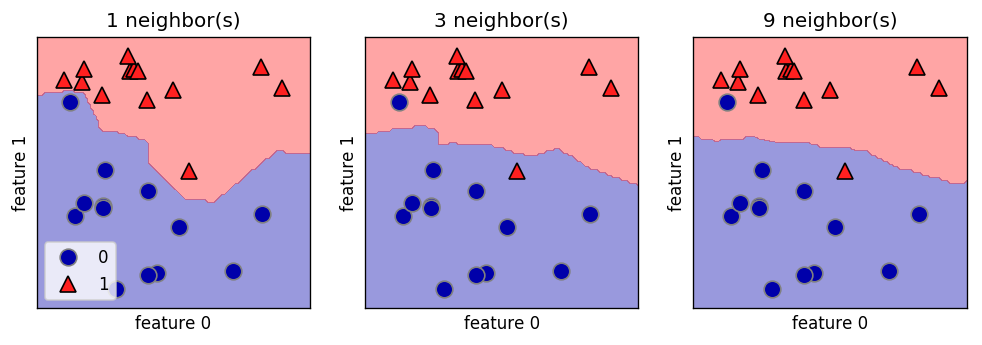

In [42]:
# Visualize predictions of kNN for different numbers of neighbors
ml.plots.plot_kNN_overfitting(k = [1, 3, 9])

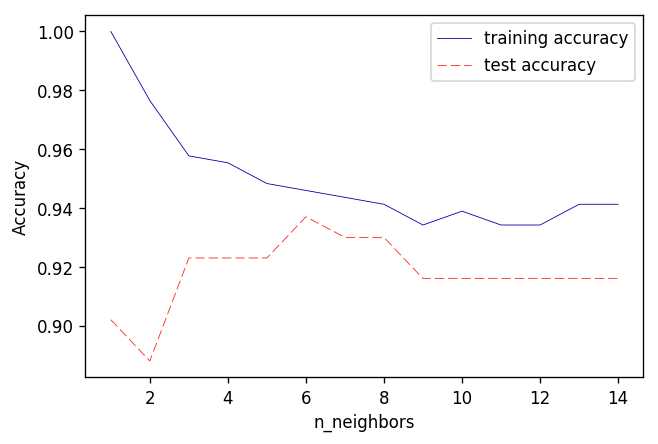

In [43]:
# Visualize performance of kNN for different numbers of neighbors
# Overfitting on the left, underfitting on the right
ml.plots.plot_kNN_overfitting_curve(k = range(1,15))

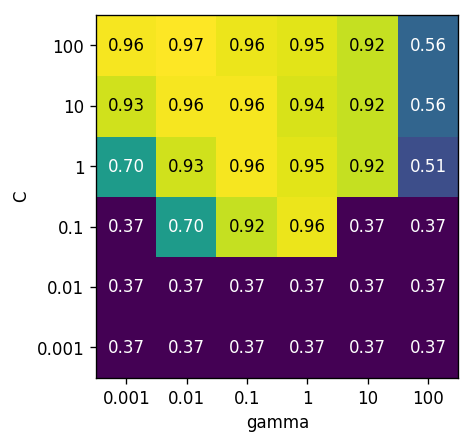

In [44]:
# Visualize performance (accuracy) of the SVM classifier on iris
ml.plots.plot_grid_results(c = [0.001, 0.01, 0.1, 1, 10, 100], gamma = [0.001, 0.01, 0.1, 1, 10, 100] )

#### Nested cross-validation

- Note that we are still using a single split to create the outer test set
- We can also use cross-validation here
- Nested cross-validation:
    - Outer loop: split data in training and test sets
    - Inner loop: run grid search, splitting the training data into train and validation sets
- There will be multiple optimized models and hyperparameter settings
- You can do this in weka with:
    - outer k-fold crossvalidation: specify in Experimenter/Explorer
    - inner 2-fold crossvalidation (fixed) with GridSearch

### Random Search

- Grid Search has a few downsides:
    - Optimizing many hyperparameters creates a combinatorial explosion
    - You have to predefine a grid, hence you may jump over optimal values
- Random Search:
    - Picks `n_iter` random parameter values
    - Scales better, you control the number of iterations
    - Often works better in practice, too
        - not all hyperparameters interact strongly
        - you don't need to explore all combinations

#### Random search in WEKA
- You have to install `MultiSearch` from the Package Manager
    - Find it as a classifier under meta > MultiSearch
    - Under `algorithm`, select `RandomSearch`
    - Under `searchparameter`, define the value range
![weka cv](./images/07_weka_multisearch.png)

## Model-based optimization

- After a number of random search iterations we know more about the performance of hyperparameter settings on the given dataset
- We can use this data to train a model, and predict which other hyperparameter values might be useful
- This is often a probabilistic (e.g. Bayesian) model that predicts confidence intervals for all hyperparameter settings


Example: Bayesian optimization (see figure): 

- Consider only 1 continuous hyperparameter (X-axis)
- Y-axis shows cross-validation performance
- Evaluate a number of random hyperparameter settings (black dots)
    - Sometimes an initialization design is used
- Train a model, and predict the expected performance of other (unseen) hyperparameter values
    - Mean value (black line) and distribution (blue band)
- An _acquisition function_ (green line) trades off maximal expected performace and maximal uncertainty
    - Exploitation vs exploration
- Optimal value of the asquisition function is the next hyperparameter setting to be evaluated
- Repeat a fixed number of times, or until time budget runs out

![BayesOpt](./images/03_Bayesian_optimization.png)

#### Model-based optimization in WEKA
- Install `AutoWEKA` from the Package Manager
    - Find it as a classifier under meta > AutoWEKAClassifier
    - Searches a fixed set of algorithms and hyperparameter ranges
    - Time limit (in minutes) best set high (e.g. a day)
![weka cv](./images/07_weka_autoweka.png)

## Evaluation Metrics and scoring
Keep the end-goal in mind

### Metrics for binary classification

- The most common (and simple) application of machine learning in practive
- We have a positive and a negative class
- Different kind of errors:
    - False Positive (type I error): model predicts positive while the true label is negative
    - False Negative (type II error): model predicts negative while the true label is positive
- Which side do you want to err on for a medical test?

#### Imbalanced datasets

- The type of error plays an even larger role if the dataset is imbalanced
    - One class is much more frequent than the other
    - This is often typical of real world data
    - E.g. credit card fraud detection
- Is a 99.99% accuracy good enough? 

#### Confusion matrices

- We can represent all predictions (correct and incorrect) in a confusion matrix
    - n by n array (n is the number of classes)
    - Rows correspond to the true classes
    - Columns correspond to the predicted classes
    - Each entry counts how often a sample that belongs to the class corresponding to the row was classified as the class corresponding to the column.
- Returned in the output of WEKA Explorer

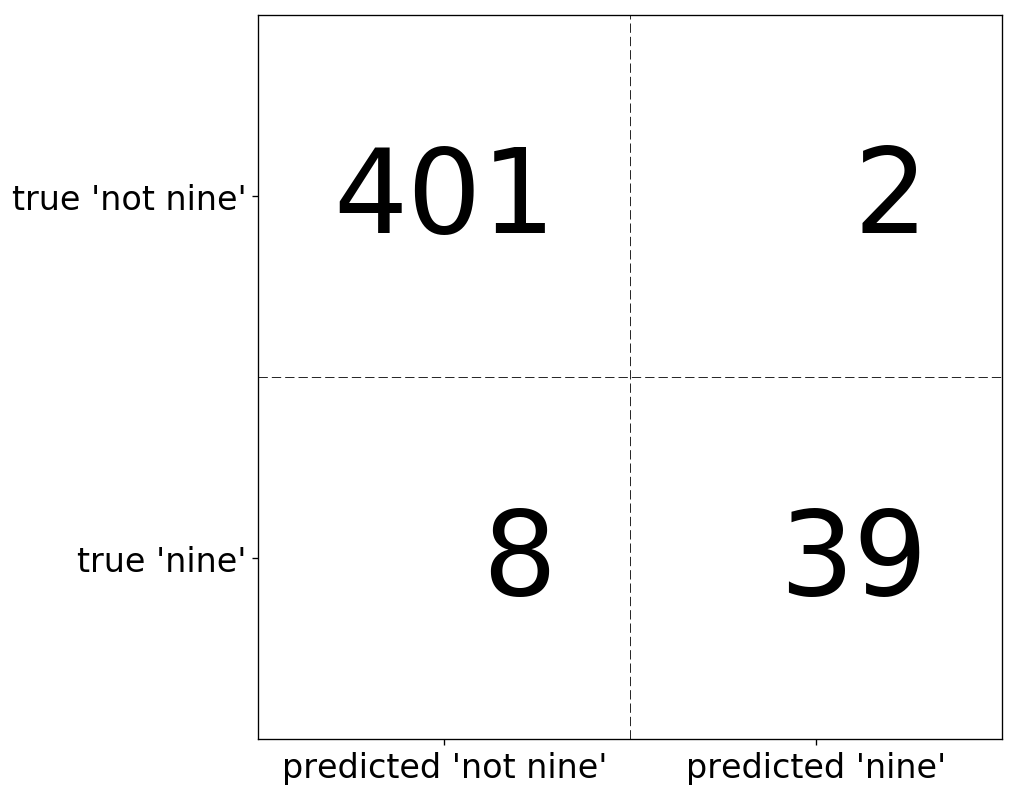

In [45]:
# Confusion matrix for the MNIST dataset (not-9 vs 9)
mglearn.plots.plot_confusion_matrix_illustration()

For binary classification, we use the following terms:

- True Negative (TN)
- False Positive (FP)
- False Negative (FN)
- True Positive (TP)

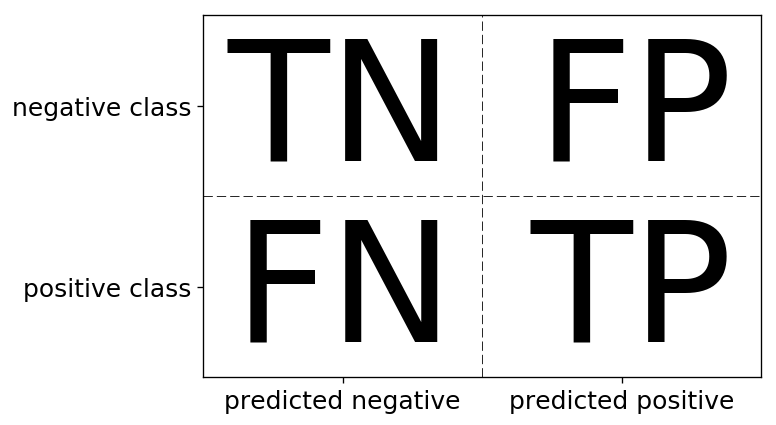

In [46]:
mglearn.plots.plot_binary_confusion_matrix()

- The results of the confusion matrix can be summarized in several ways. 
- These are all returned in the WEKA Experimenter

- We already know accuracy (percent correct):

\begin{equation}
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
\end{equation}

__Precision__ is used when the goal is to limit FPs
- Clinical trails: you only want to test drugs that really work
- Search engines: you want to avoid bad search results

\begin{equation}
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
\end{equation}

__Recall__ is used when the goal is to limit FNs
- Cancer diagnosis: you don't want to miss a serious disease
- Search engines: You don't want to omit important hits
- Also know as sensitivity, hit rate, true positive rate (TPR)

\begin{equation}
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
\end{equation}

__F1-score__ or F1-measure trades of precision and recall:

\begin{equation}
\text{F} = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}
\end{equation}

- To study all of them at once, use `classification_report`
    - Support: number of samples in each class
    - Last line: weighted average over the classes (weighted by number of smaples in each class)

#### Taking uncertainty into account

- Many classifiers actually return a probability per class
- For binary classification, we _threshold_ the probabilities
    - E.g. > 0.5 means class 1, otherwise class 0
- Depending on the evaluation measure, you may want to threshold differently to fit your goals
    - For instance, when a FP is much worse than a FN
    - This is called _threshold calibration_

##### Visualization
- Imagine that we want to avoid misclassifying a red point
- The black line shows the threshold: points within are classified positive (red)
- By changing the decision treshold, more points will be classified positive

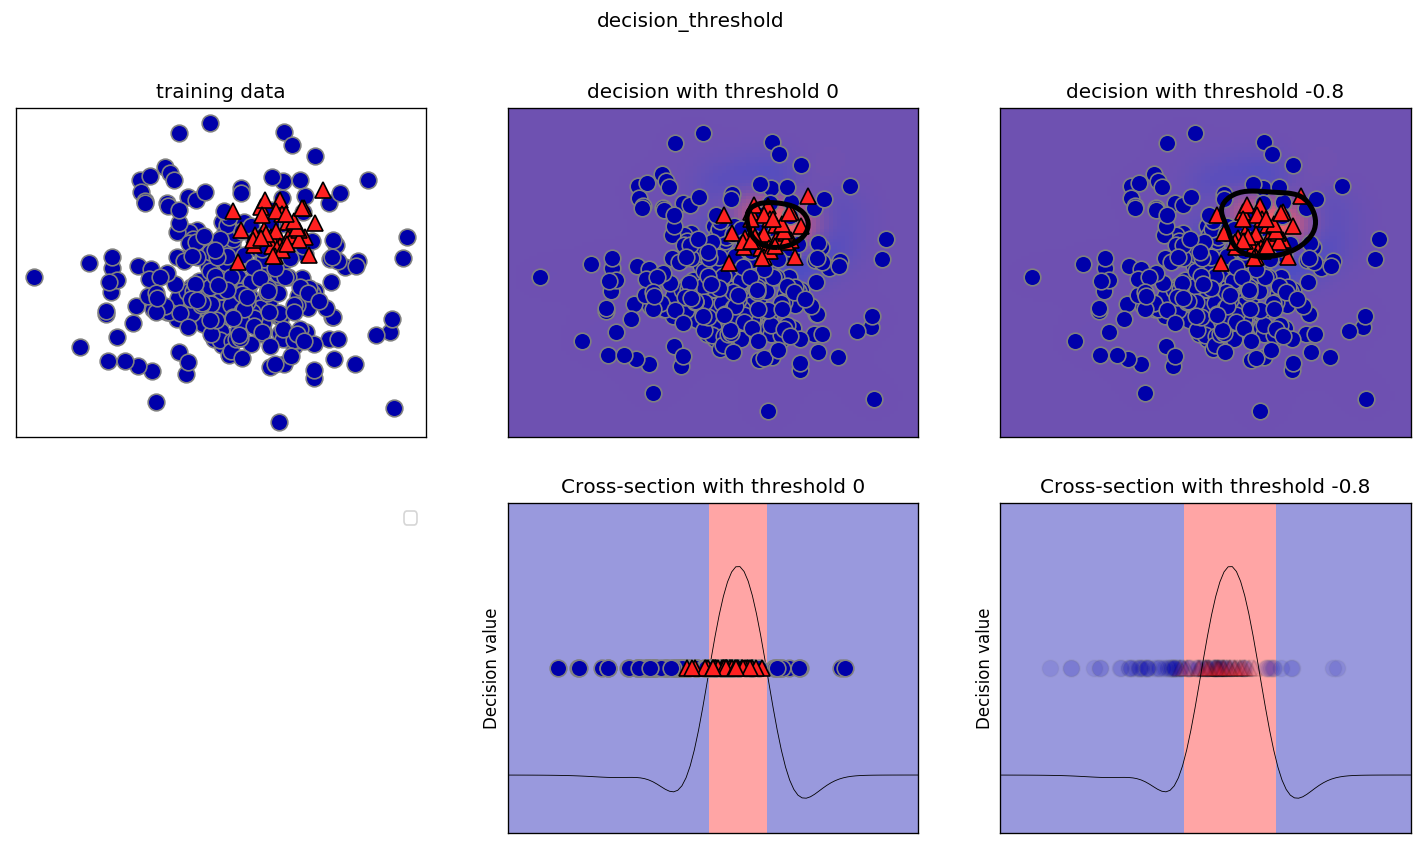

In [47]:
mglearn.plots.plot_decision_threshold()

### Precision-Recall curves

- The right threshold depends on your application, should be driven by business goals.
- You can have arbitrary high recall, but you often want reasonable precision, too.
- It is not clear beforehand where the optimale trade-off (or _operating point_) will be, so it is useful to look at all possible thresholds
- Plotting precision against recall for all thresholds yields a __precision-recall curve__
 


- Now we can plot the curve. The default tradeoff (chosen by the `predict` method) is indicated as _threshold zero_.
- The closer the curve stays to the upper-right corner, the better
    - High precision and high recall
- Here, it is possible to still get a precision of 0.5 with high recall

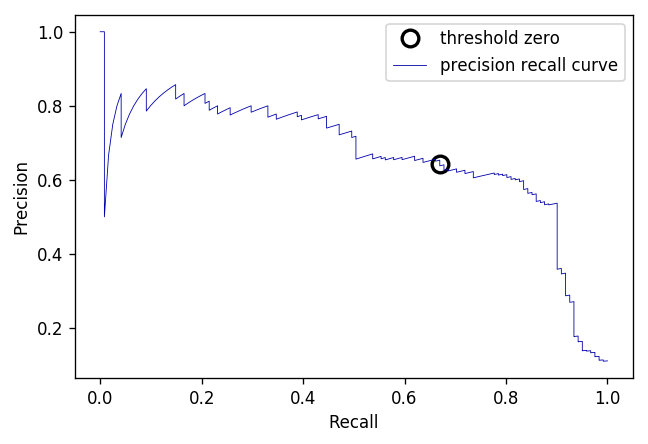

In [93]:
# create a similar dataset as before, but with more samples
# to get a smoother curve
ml.plots.plot_precision_recall_curve()

#### Model selection

- Different classifiers work best in different parts of the curve (at different operating points)
- Let's compare two classifiers (we'll see both soon)
- The RandomForest (in red) performs better at the extremes
- The area under the precision-recall curve (AUPRC) is often used as a general evaluation measure

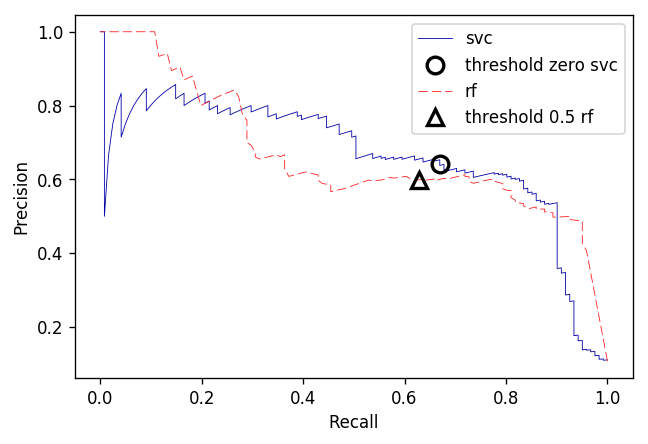

In [71]:
ml.plots.plot_precision_recall_select()

- The area under the precision-recall curve is returned by the `average_precision_score` measure 
    - It's actually a close approximation of the actual area
- This is a good automatic measure, but also hides the subtleties

### Receiver Operating Characteristics (ROC) and AUC

- There is another trade-off between recall (true positive rate, TPR) and the false positive rate (FPR).
- The 2D space created by TPR and FPR is called the Receiver Operating Characteristics (ROC) space
- A model will be at one point in this ROC space

\begin{equation}
\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}
\end{equation}

\begin{equation}
\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
\end{equation}

- Varying the decision threshold yields the ROC curve
- It can be computed with the `roc_curve` function
- Ideal is close to the top left: high recall, low FPR
- Inspect the curve to find the preferred calibration
    - Here, we can get much higher recall with slightly worse FPR

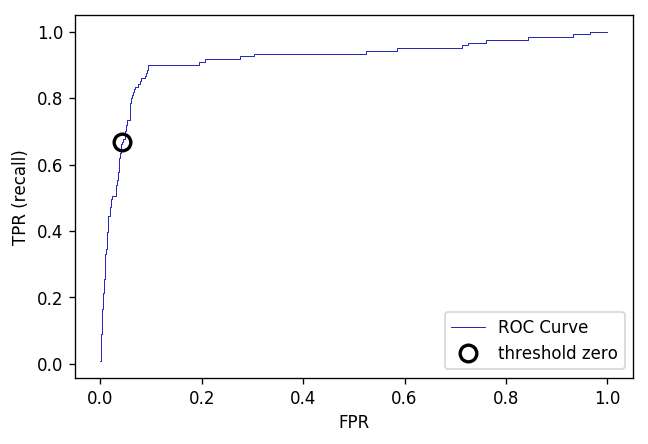

In [84]:
ml.plots.plot_roc()

#### Visualization

- Imagine 2 overlapping distributions (positive red class, negative blue class)
- All points to the right of the threshold are predicted positive, others negative
- As we increase the threshold, we'll get fewer FPs, more FNs
    - Perfect classifier would perfectly separate the classes
    - For a random classifier, the distributions overlap completely

![roc](./images/03_roc.png)

#### ROC Isometrics
- Different _costs_ can be involved for FP and FN
- This yields different _isometrics_ (lines of equal cost) in ROC space
- The optimal threshold is the point on the ROC curve where the cost in minimal
    - If a FP and FN are weigthed equally, cost lines follow the diagonal (blue line)
    - If a FP is 10 times worse than a FN: pink line
    - IF a FN is 10 times worse than a FP: red line

![ROC cost curves](./images/03_roc_cost.png)

#### Model selection

- Again, we can compare multiple models by looking at the ROC curves
- We can calibrate the threshold depending on whether we need high recall or low FPR
- We can select between algorithms (or hyperparameters) depending on the involved costs.

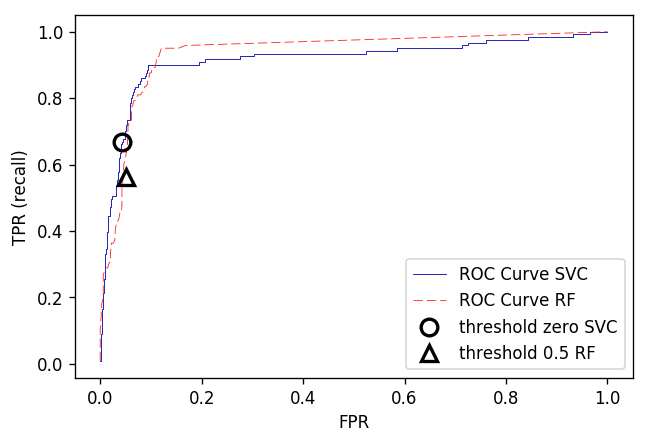

In [128]:
ml.plots.plot_roc_select()

#### Area under the ROC curve

- A good summary measure is the area under the ROC curve (AUROC or AUC)

#### Imbalanced classes
- AUC is popular because it is insensitive to class imbalance
    - Random guessing yields TPR=FPR no matter what the class imbalance is
    - All points are on the diagonal line, hence an AUC of 0.5
    - Hint: use the visualization of TPR,FPR to see this
- Example: unbalanced digits
    - 3 models, ACC is the same, AUC not
    - If we optimize for ACC, our model could be just random guessing

gamma = 1.000  accuracy = 0.90  AUC = 0.5000
gamma = 0.100  accuracy = 0.90  AUC = 0.9582
gamma = 0.010  accuracy = 0.90  AUC = 0.9995


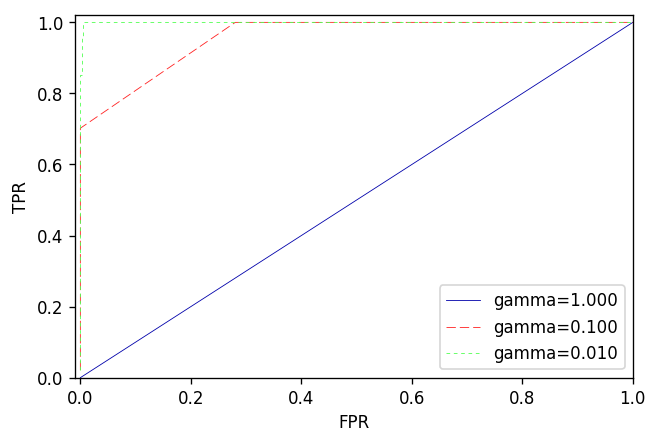

In [132]:
ml.plots.plot_roc_imbalanced()

#### Take home message

- AUC is highly recommended, especially on imbalanced data
- Remember to calibrate the threshold to your needs

### Multi-class classification

- Multiclass metrics are derived from binary metrics, averaged over all classes
- Let's consider the full (10-class) handwritten digit recognition data

Confusion matrix

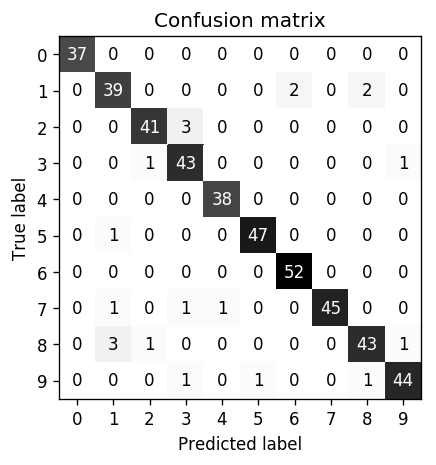

In [151]:
ml.plots.plot_confusion_matrix()

Different ways to compute average

- macro-averaging: computes unweighted per-class scores: 
$\frac{\sum_{i=0}^{n}score_i}{n}$
    - Use when you care about each class equally much

- weighted averaging: scores are weighted by the relative size of the classes (support): 
$\frac{\sum_{i=0}^{n}score_i weight_i}{n}$
    - Use when data is imbalanced
    - Default in WEKA

- micro-averaging: computes total number of FP, FN, TP over all classes, them computes scores using these counts: 
$recall = \frac{\sum_{i=0}^{n}TP_i}{\sum_{i=0}^{n}TP_i + \sum_{i=0}^{n}FN_i}$
    - Use when you care about each sample equally much

## Regression metrics

Most commonly used are
- (root) mean squared error: $\frac{\sum_{i}(y_{pred_i}-y_{actual_i})^2}{n}$
- mean absolute error: $\frac{\sum_{i}|y_{pred_i}-y_{actual_i}|}{n}$
    - Less sensitive to outliers and large errors
- R squared (r2)
    - Ratio of variation explained by the model / total variation
    - Always between 0 and 1, easier to interpret (higher is better)
    - Does not measure bias. Look at the residuals to make sure.

# Summary

- k-fold Cross-validation
    - Choose k depending on how much data you have
        - Larger k is slower, but allows more training data
        - 10-fold, 5-fold, 5x2-fold most popular
    - Always use stratification for (imbalanced) classification
    - Train-test split and Shuffle-split: useful for large datasets 
    - Use grouping when you want to generalize over groups
- Model selection
    - Don't aggregate over test scores: those have seen the test data
    - Use validation sets to choose algorithms/hyperparameters first
- Optimization
    - Grid Search: exhaustive but simple
    - Random Search: scales better
    - Model-based optimization: more efficient, scales better
- Evaluation measures
    - High accuracy is seldom the true goal
    - Choose metric depending on how you will use the model
    - Real world data is often imbalanced, has different costs for FP, FN